In [31]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec
import seaborn as sns
import matplotlib.pyplot as plt

Scraping today's headlines from major news websites:

In [32]:
# Function to scrape headlines from a given URL
def scrape_headlines(url, tag_name, class_name):
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        headlines = soup.find_all(tag_name, class_=class_name)
        return [headline.text.strip() for headline in headlines]
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from {url}: {e}")
        return []

# MSNBC
msnbc_url = 'https://www.msnbc.com/'
msnbc_headlines = scrape_headlines(msnbc_url, 'h3', 'styles_headline__vGca_') #Working

# BBC
bbc_url = 'https://www.bbc.com/'
bbc_headlines = scrape_headlines(bbc_url, 'h3', 'media__title') #Working

# NPR
npr_url = 'https://www.npr.org/'
npr_headlines = scrape_headlines(npr_url, 'h3', 'title') #Working

# Print headlines
print("MSNBC Headlines:")
for i, headline in enumerate(msnbc_headlines, start=1):
    print(f"{i}. {headline}")

print("\nBBC Headlines:")
for i, headline in enumerate(bbc_headlines, start=1):
    print(f"{i}. {headline}")

print("\nNPR Headlines:")
for i, headline in enumerate(npr_headlines, start=1):
    print(f"{i}. {headline}")


MSNBC Headlines:
1. Israel's next move could reshape the world. America knows those stakes too well.
2. I was Steve Scalise's constituent. Don't trust him.
3. Kevin McCarthy’s problems pale in comparison to what Steve Scalise could soon face
4. The House GOP 'chaos caucus' is turning our democracy into a laughing stock
5. Preschool will become a luxury if Congress doesn’t act
6. Trump's absurd 'immunity' argument is doomed to fail. But when?
7. The children of Gaza cannot escape Israel’s siege. And Netanyahu knows it.
8. Iran and Saudi Arabia care about one thing. It's not the plight of the Palestinians.
9. Before you hit post on that Israel-Hamas war statement, read this
10. Fox News host endorses civil war, claiming ‘elections don’t work’

BBC Headlines:
1. 'Oh god, they’re here’: Hamas massacre captured on Israeli mothers’ WhatsApp group
2. Three ways US Republican Speaker chaos ends
3. Air Canada sued over $20m gold and cash heist
4. Swift's formidable financial power
5. Emma Stone

**Sentiment Analysis**

Load training/testing dataset


In [33]:

csv_url = "http://ianvetter.cyou/sentiment_data.csv"
local_filename = "data.csv"
response = requests.get(csv_url)

if response.status_code == 200:
    with open(local_filename, 'wb') as file:
        file.write(response.content)
    print(f"Downloaded {local_filename}")
else:
    print(f"Failed to download {csv_url}")

data = pd.read_csv('data.csv')
data.head()


Downloaded data.csv


,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,-1,-1,-1,0.000000,-0.053300
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,-1,-1,-1,0.208333,-0.156386
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-1,-1,-1,-0.425210,0.139754
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,-1,-1,-1,0.000000,0.026064
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,-1,-1,-1,0.000000,0.141084


Model  (LSTM regression into sentiment score)

In [34]:

headlines = data["Title"]
sentiments = data["SentimentTitle"]

# Tokenize and create a sequence of word indices for each headline
def tokenize_and_index(headlines, word_to_index, max_length):
    indexed_headlines = []
    for headline in headlines:
        tokens = headline.split()
        indexed_sequence = [word_to_index[token] if token in word_to_index else word_to_index['<UNK>'] for token in tokens]
        padding = [word_to_index['<PAD>']] * (max_length - len(indexed_sequence))
        indexed_headline = indexed_sequence + padding
        indexed_headlines.append(indexed_headline)
    return np.array(indexed_headlines)

# Create a vocabulary and word-to-index mapping
word_to_index = {'<PAD>': 0, '<UNK>': 1}
max_tokens = 0
for headline in headlines:
    tokens = headline.split()
    if (len(tokens) > max_tokens):
      max_tokens = len(tokens)
    for token in tokens:
        if token not in word_to_index:
            word_to_index[token] = len(word_to_index)


# Pad sequences to a fixed length
max_sequence_length = max_tokens + 2
X = tokenize_and_index(headlines, word_to_index, max_sequence_length)
y = np.array(sentiments, dtype=np.float32)  # Convert sentiments to float32

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.int64)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, lin_dim, output_dim):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, lin_dim)
        self.fc2 = nn.Linear(lin_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        hidden, _ = self.rnn(embedded)
        output = self.fc1(hidden)
        output = self.fc2(output[:, -1, :])  # Get the last output of the sequence
        return output

# Define hyperparameters
vocab_size = len(word_to_index)
embedding_dim = 50
hidden_dim = 32
lin_dim = 16
output_dim = 1  # Output dimension for regression

learning_rate = 0.0005
batch_size = 64
num_epochs = 10

# Create the model
model = SentimentModel(vocab_size, embedding_dim, hidden_dim, lin_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

trlosses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions.squeeze(), batch_y)  # Squeeze to match dimensions
        loss.backward()
        optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
        trlosses.append(loss.item())

telosses = []
# Evaluation
model.eval()
with torch.no_grad():
    test_loss = 0
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)
        telosses.append(criterion(predictions.squeeze(), batch_y).item())
        test_loss += criterion(predictions.squeeze(), batch_y).item()

    test_loss /= len(test_loader)

print(f'Mean Squared Error on the test set: {test_loss:.4f}')


Streaming output truncated to the last 5000 lines.
Epoch [3/10], Loss: 0.016491170972585678
Epoch [3/10], Loss: 0.012461487203836441
Epoch [3/10], Loss: 0.014152487739920616
Epoch [3/10], Loss: 0.012615608051419258
Epoch [3/10], Loss: 0.012081153690814972
Epoch [3/10], Loss: 0.01783565618097782
Epoch [3/10], Loss: 0.015429932624101639
Epoch [3/10], Loss: 0.014985695481300354
Epoch [3/10], Loss: 0.012890944257378578
Epoch [3/10], Loss: 0.01408335380256176
Epoch [3/10], Loss: 0.01159138698130846
Epoch [3/10], Loss: 0.01473905611783266
Epoch [3/10], Loss: 0.008663763292133808
Epoch [3/10], Loss: 0.0076667992398142815
Epoch [3/10], Loss: 0.009313675574958324
Epoch [3/10], Loss: 0.0120588643476367
Epoch [3/10], Loss: 0.012617858126759529
Epoch [3/10], Loss: 0.019869208335876465
Epoch [3/10], Loss: 0.01184818334877491
Epoch [3/10], Loss: 0.01227461826056242
Epoch [3/10], Loss: 0.006941486150026321
Epoch [3/10], Loss: 0.009082469157874584
Epoch [3/10], Loss: 0.017785057425498962
Epoch [3/10],

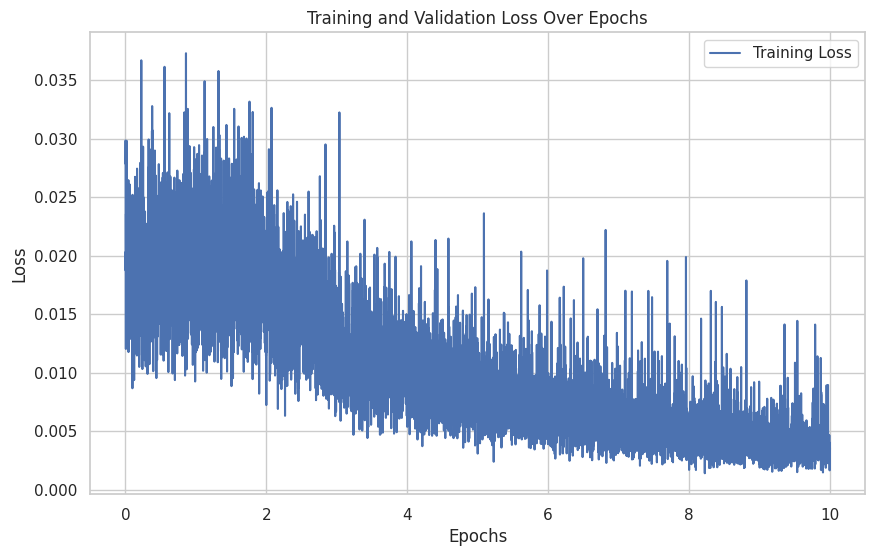

In [36]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.linspace(0, 10, len(trlosses)), y=trlosses, label="Training Loss", linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")

# Add legend
plt.legend()

# Show the plot
plt.show()

Test out on today's headlines!

In [53]:

input = torch.tensor(tokenize_and_index(bbc_headlines, word_to_index, max_sequence_length))
print(input[0].reshape(-1, 1).shape)
sentiment_scores = model(input[0].reshape(-1,1))
print(sentiment_scores)

torch.Size([26, 1])
tensor([[-0.0734],
        [-0.0734],
        [-0.0734],
        [-0.0734],
        [-0.1423],
        [-0.0682],
        [-0.0166],
        [-0.1004],
        [-0.1315],
        [-0.0734],
        [-0.1020],
        [-0.0465],
        [-0.0665],
        [-0.0665],
        [-0.0665],
        [-0.0665],
        [-0.0665],
        [-0.0665],
        [-0.0665],
        [-0.0665],
        [-0.0665],
        [-0.0665],
        [-0.0665],
        [-0.0665],
        [-0.0665],
        [-0.0665]], grad_fn=<AddmmBackward0>)


In [54]:
bbc_input = torch.tensor(tokenize_and_index(bbc_headlines, word_to_index, max_sequence_length))
bbc_sentiment_scores = model(bbc_input)

msnbc_input = torch.tensor(tokenize_and_index(msnbc_headlines, word_to_index, max_sequence_length))
msnbc_sentiment_scores = model(msnbc_input)

npr_input = torch.tensor(tokenize_and_index(npr_headlines, word_to_index, max_sequence_length))
npr_sentiment_scores = model(npr_input)

msnbc_sentiments = []
bbc_sentiments = []
npr_sentiments = []

print("\nMSNBC Headlines:")
for i, headline in enumerate(msnbc_headlines, start=1):
    print(f"{i}. {headline}", "\n", " Sentiment Score: ", round(float(msnbc_sentiment_scores[i-1]), 2), "\n")

print("\nBBC Headlines:")
for i, headline in enumerate(bbc_headlines, start=1):
    print(f"{i}. {headline}", "\n", " Sentiment Score: ", round(float(bbc_sentiment_scores[i-1]), 2), "\n")

print("\nNPR Headlines:")
for i, headline in enumerate(npr_headlines, start=1):
    print(f"{i}. {headline}", "\n", " Sentiment Score: ", round(float(npr_sentiment_scores[i-1]), 2), "\n")



MSNBC Headlines:
1. Israel's next move could reshape the world. America knows those stakes too well. 
  Sentiment Score:  0.05 

2. I was Steve Scalise's constituent. Don't trust him. 
  Sentiment Score:  0.12 

3. Kevin McCarthy’s problems pale in comparison to what Steve Scalise could soon face 
  Sentiment Score:  -0.18 

4. The House GOP 'chaos caucus' is turning our democracy into a laughing stock 
  Sentiment Score:  0.0 

5. Preschool will become a luxury if Congress doesn’t act 
  Sentiment Score:  -0.09 

6. Trump's absurd 'immunity' argument is doomed to fail. But when? 
  Sentiment Score:  -0.01 

7. The children of Gaza cannot escape Israel’s siege. And Netanyahu knows it. 
  Sentiment Score:  -0.08 

8. Iran and Saudi Arabia care about one thing. It's not the plight of the Palestinians. 
  Sentiment Score:  -0.13 

9. Before you hit post on that Israel-Hamas war statement, read this 
  Sentiment Score:  0.09 

10. Fox News host endorses civil war, claiming ‘elections don’

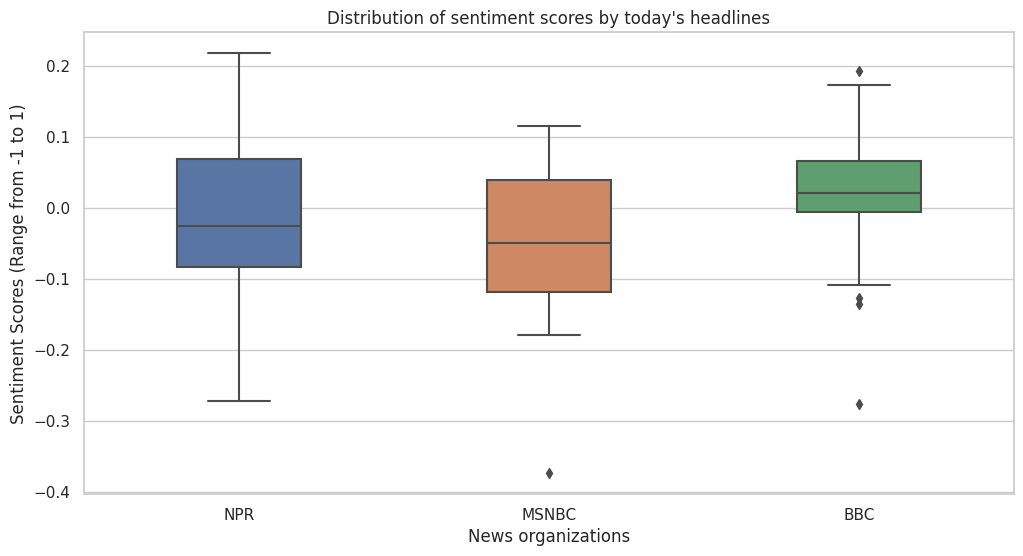

In [57]:

sns.set(style="whitegrid")

# Combine the data into a single list for plotting
combined_data = [npr_sentiment_scores.detach().numpy(), msnbc_sentiment_scores.detach().numpy(), bbc_sentiment_scores.detach().numpy()]
labels = ["NPR", "MSNBC", "BBC"]

# Create a boxplot for the three data sets
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_data, width=0.4)

# Set plot labels and title
plt.xlabel("News organizations")
plt.ylabel("Sentiment Scores (Range from -1 to 1)")
plt.title("Distribution of sentiment scores by today's headlines")

# Set x-axis labels
plt.xticks(range(3), labels)

# Show the plot
plt.show()